In [1]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
from bff_processor.plotting_utils import unc_plot, boost2unc
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom, chiSquared, color_map, quad, linear, constant
import os
import re
from time import perf_counter
import boost_histogram as bh
import pyarrow.feather as feather
import zfit
from zfit import z
from math import pi
import mplhep as hep
hep.style.use(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})
from zfit.models.physics import DoubleCB
from scipy.optimize import curve_fit
from zfit.models.physics import double_crystalball_func

from bff_plotting_tools.make_hists import make_hist
from bff_plotting_tools.data_getter import get_data
from bff_signal_model.bff_signal_model import bff_signal_model, reset_params, mu

ImportError: cannot import name 'quad' from 'bff_processor.utils' (/home/ryan/Develop/Physics/bff_plotting_code_v3/bff_processor/utils.py)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle

In [4]:
x_range = [110,800]
obs = zfit.Space("x", limits=x_range)

In [5]:
era = '2016'
df, lumi = get_data(era)
compute_hesse=True

In [53]:
from bff_signal_model.utils import get_unique_masses, make_plot_dict, make_stack_plot, compute_bin_centers, sigma_from_mass

In [30]:
masses = get_unique_masses(df)
#masses = np.array([150])
plot_dict,plot_dict_centered, param_list = make_plot_dict(df, obs, masses, compute_hesse=compute_hesse)

125.0
150.0
175.0
200.0
350.0
500.0
125.0
150.0
175.0
200.0
350.0
500.0


In [31]:
pdf = pd.DataFrame(param_list)
pdf['fitted mass'] = pdf.mu/.995 - 0.57839198
pdf

,reg,mass,mu,mu_error,fitted mass
0,SR1,125.0,125.021510,0.000700,125.071366
1,SR1,150.0,149.897327,0.000544,150.072188
2,SR1,175.0,174.765675,0.000588,175.065502
3,SR1,200.0,199.727921,0.000519,200.153187
4,SR1,350.0,349.084519,0.001282,350.260320
5,SR1,500.0,498.411681,0.002579,500.337870
6,SR2,125.0,124.930788,0.001209,124.980189
7,SR2,150.0,149.880529,0.001168,150.055306
8,SR2,175.0,174.737909,0.001414,175.037597
9,SR2,200.0,199.646988,0.001141,200.071847


In [32]:
if compute_hesse: pdf.to_csv('fits/bff/bff_mass_only_model_fit_{}.csv'.format(era))

[]
[]


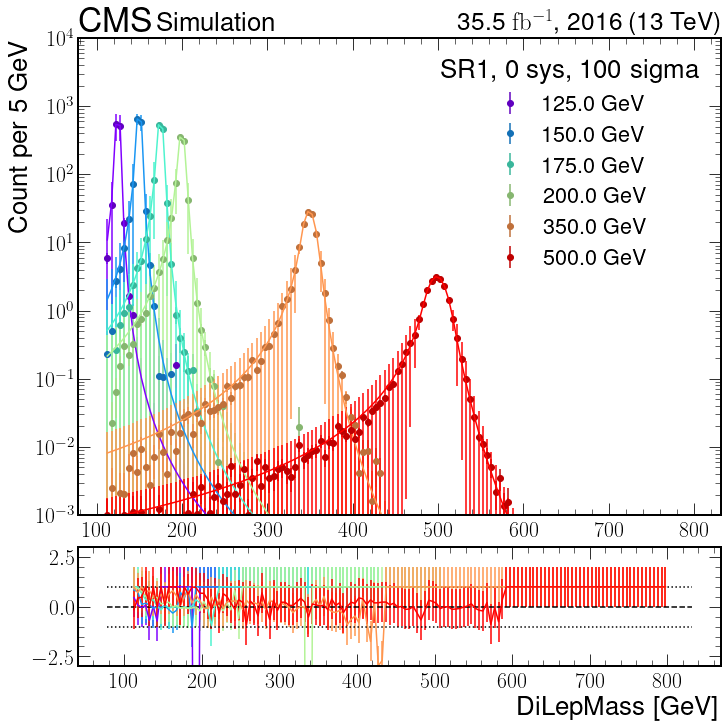

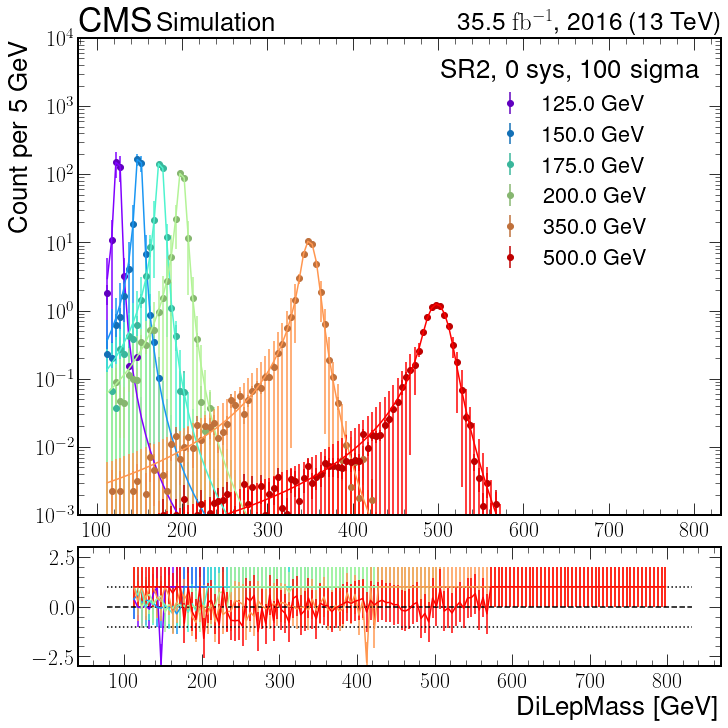

In [33]:
_ = make_stack_plot(plot_dict, masses, pdf, lumi, era, compute_hesse, yscale='log')

In [34]:
pdf

,reg,mass,mu,mu_error,fitted mass,chi2
0,SR1,125.0,125.021510,0.000700,125.071366,0.835087
1,SR1,150.0,149.897327,0.000544,150.072188,0.749329
2,SR1,175.0,174.765675,0.000588,175.065502,0.717453
3,SR1,200.0,199.727921,0.000519,200.153187,0.712504
4,SR1,350.0,349.084519,0.001282,350.260320,0.641293
5,SR1,500.0,498.411681,0.002579,500.337870,0.430337
6,SR2,125.0,124.930788,0.001209,124.980189,0.838536
7,SR2,150.0,149.880529,0.001168,150.055306,0.760463
8,SR2,175.0,174.737909,0.001414,175.037597,0.757403
9,SR2,200.0,199.646988,0.001141,200.071847,0.742620


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


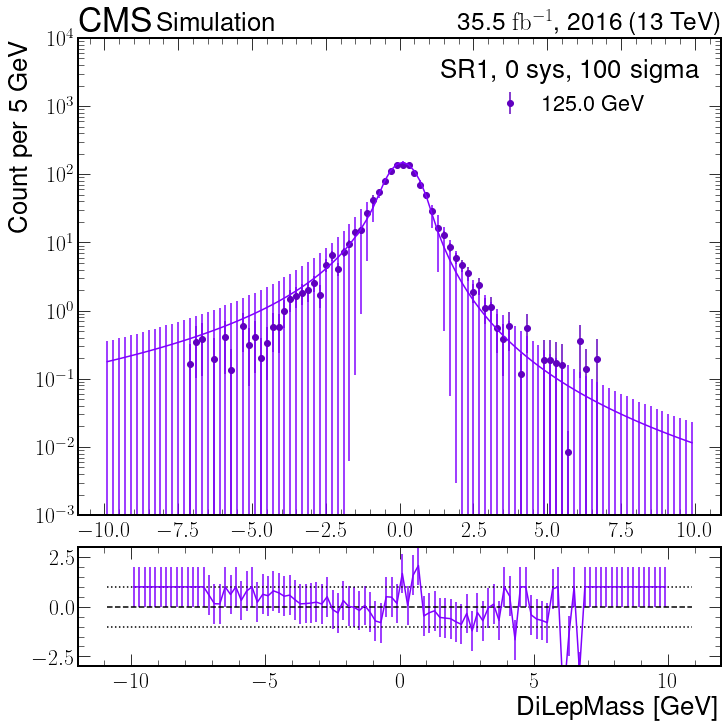

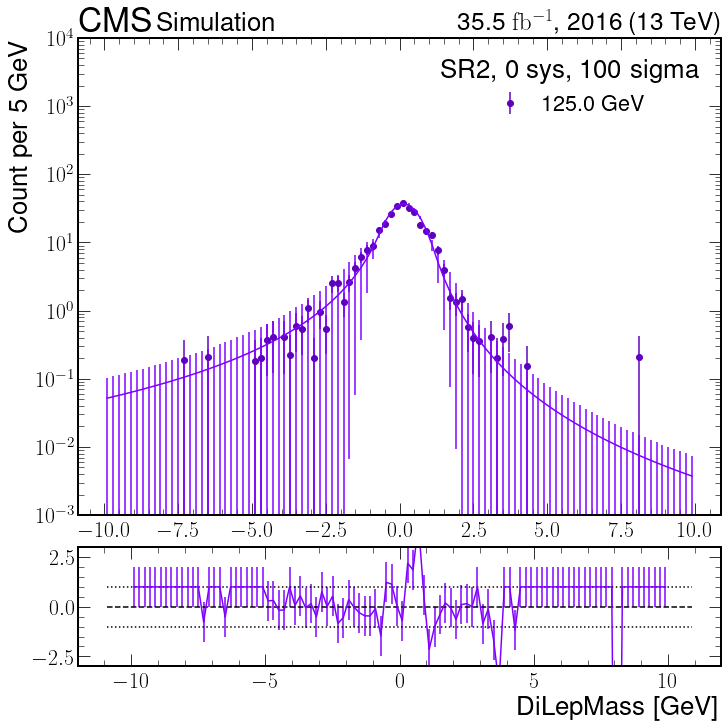

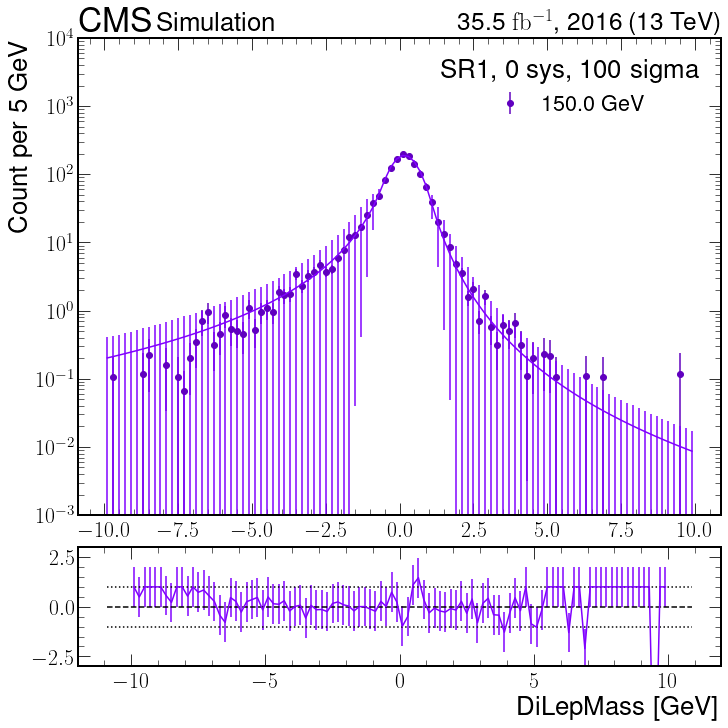

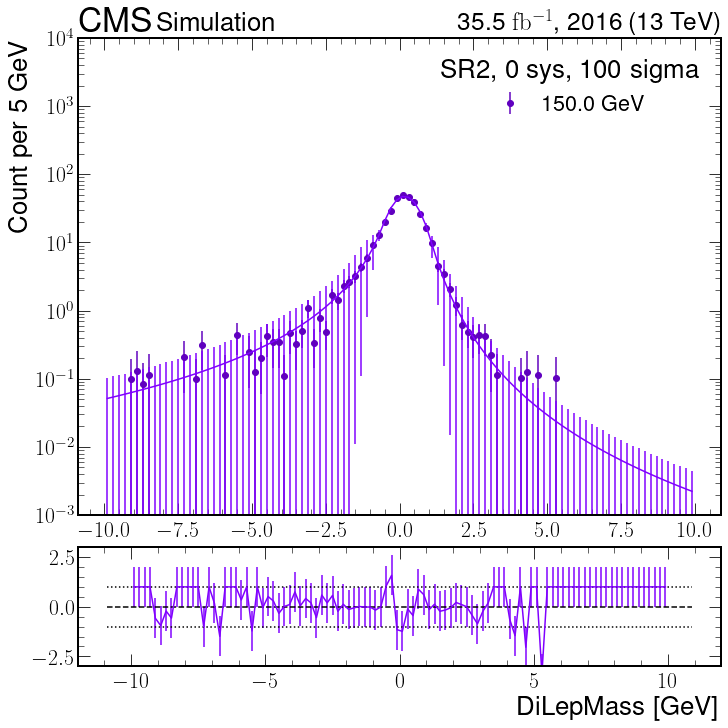

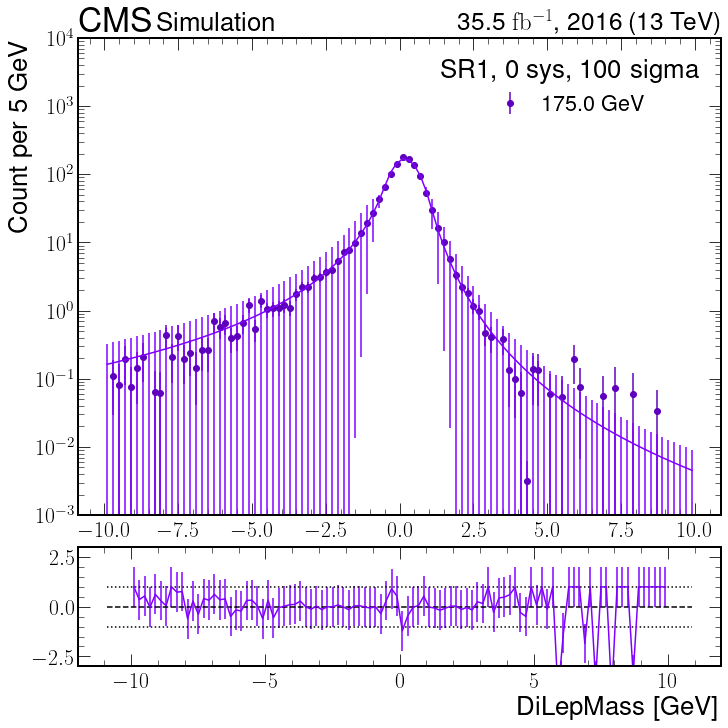

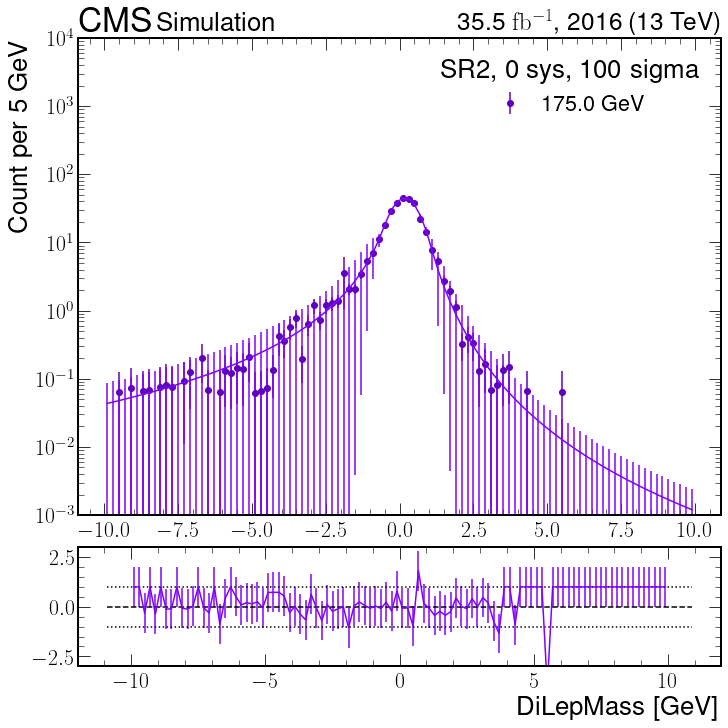

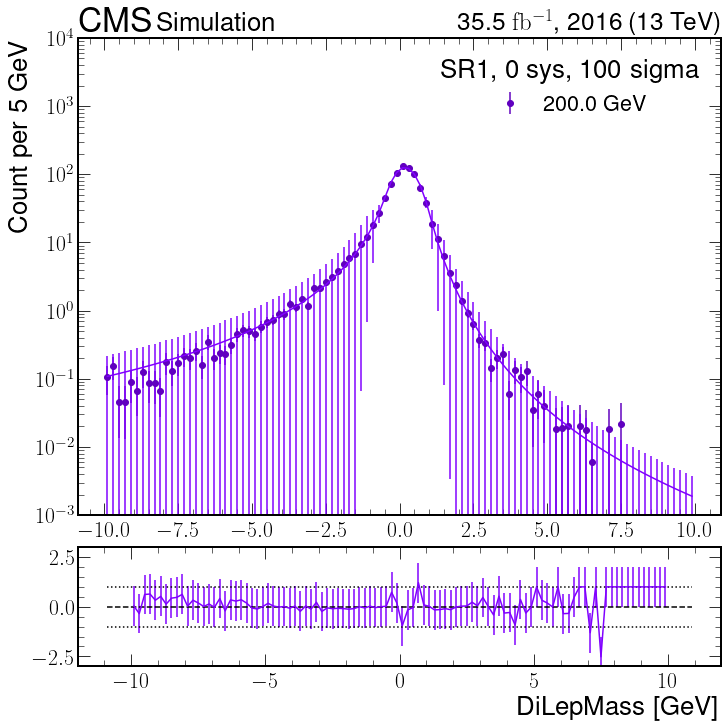

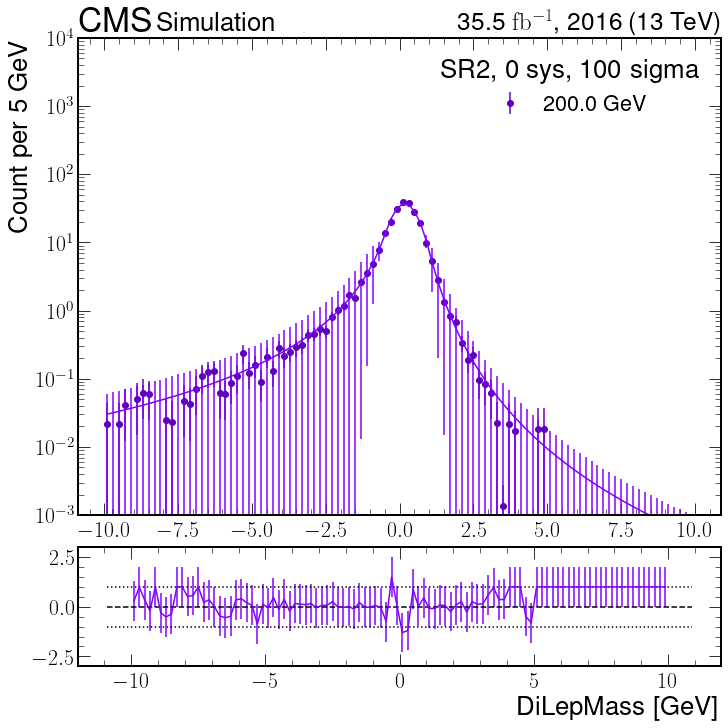

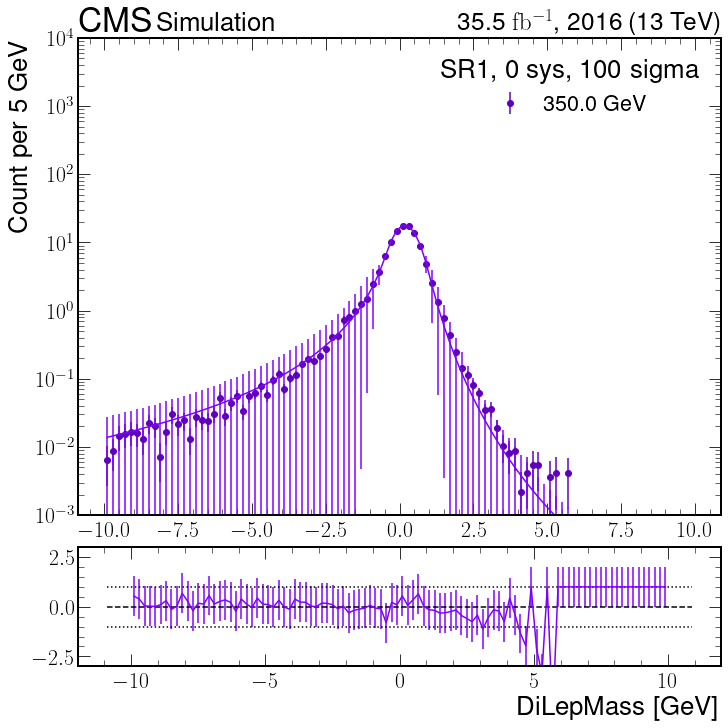

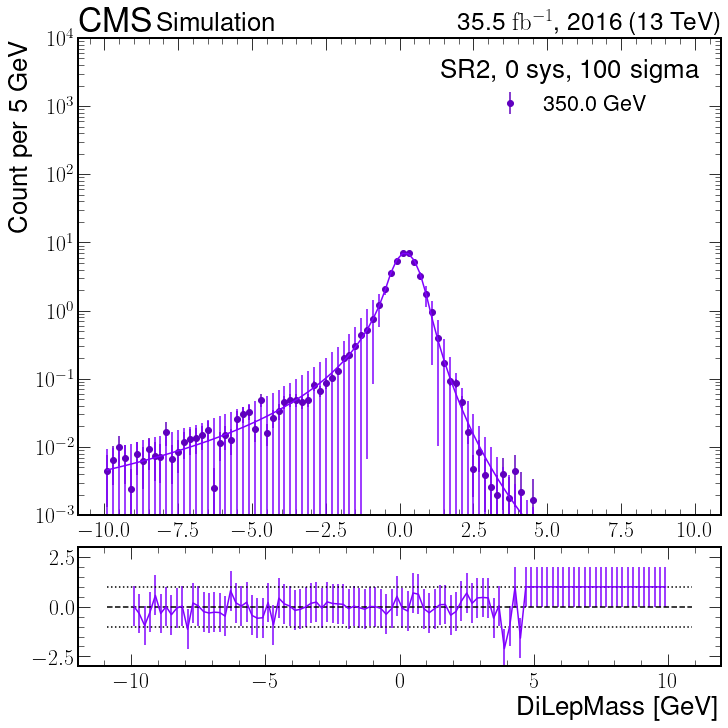

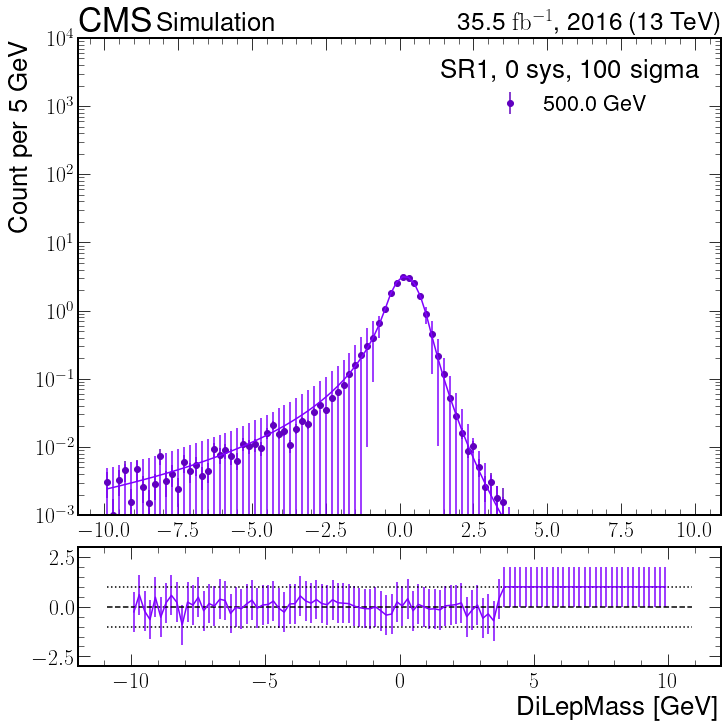

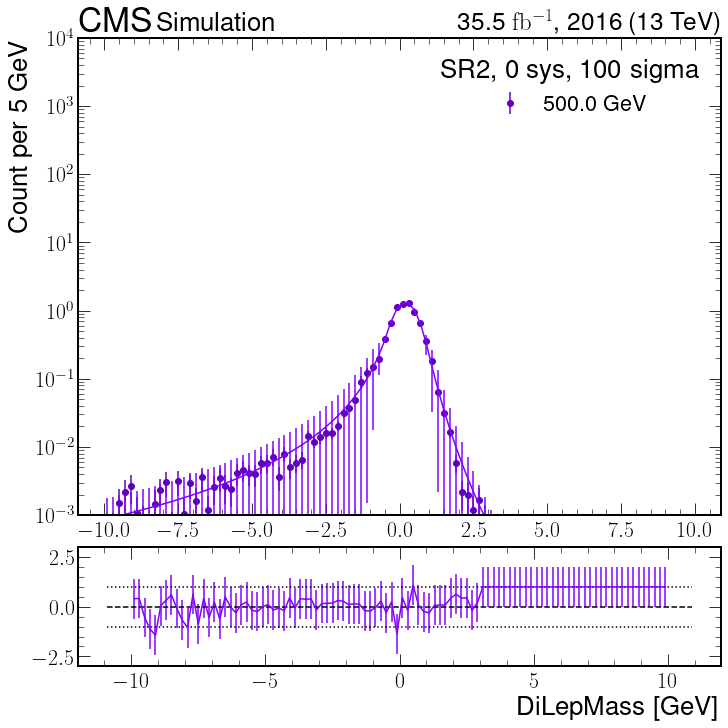

In [35]:
for mass in masses:
    make_stack_plot(plot_dict_centered, [mass], pdf, lumi, era, compute_hesse,postfix="_{}".format(mass))

[]
[]


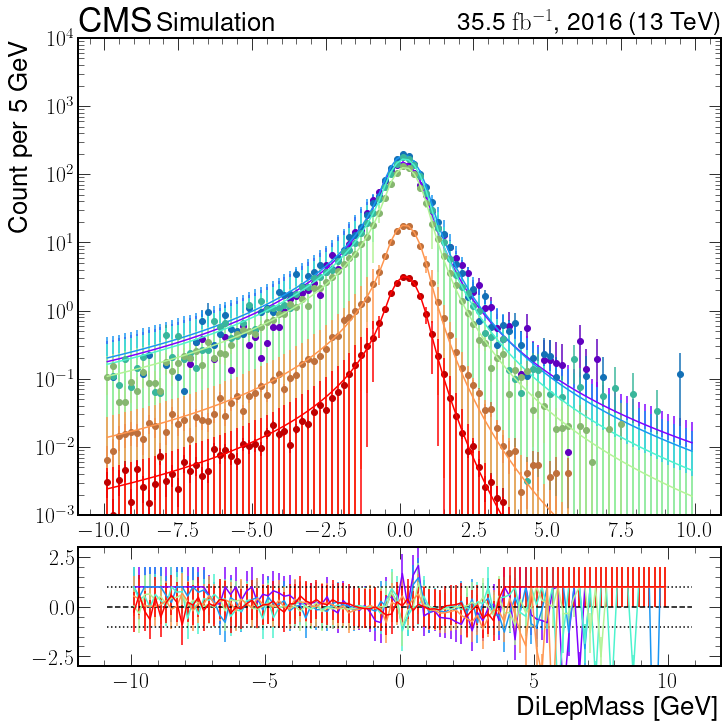

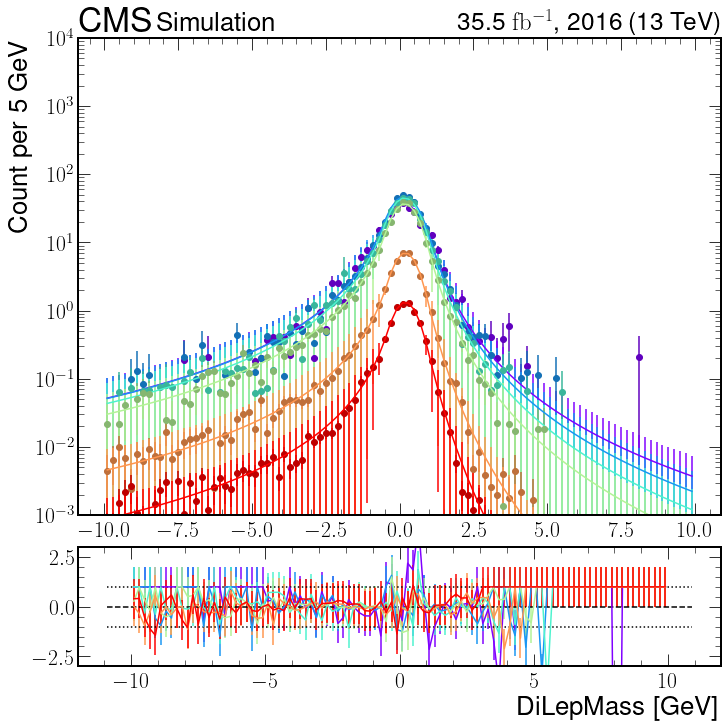

In [36]:
residual_dict = make_stack_plot(plot_dict_centered, masses, pdf, lumi, era, compute_hesse, legend=False,
                              bottom_limit=[-3,3], postfix="_centered")

In [37]:
if compute_hesse: pdf.to_csv('fits/bff/bff_mass_only_model_fit_{}.csv'.format(era))
pdf

,reg,mass,mu,mu_error,fitted mass,chi2
0,SR1,125.0,125.021510,0.000700,125.071366,0.586190
1,SR1,150.0,149.897327,0.000544,150.072188,0.426809
2,SR1,175.0,174.765675,0.000588,175.065502,0.348771
3,SR1,200.0,199.727921,0.000519,200.153187,0.255682
4,SR1,350.0,349.084519,0.001282,350.260320,0.356730
5,SR1,500.0,498.411681,0.002579,500.337870,0.370244
6,SR2,125.0,124.930788,0.001209,124.980189,0.746613
7,SR2,150.0,149.880529,0.001168,150.055306,0.543171
8,SR2,175.0,174.737909,0.001414,175.037597,0.471842
9,SR2,200.0,199.646988,0.001141,200.071847,0.427065


In [15]:
print(pdf.round(3).to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  reg &   mass &       mu &  mu\_error &  fitted mass &   chi2 \\
\midrule
0  &  SR1 &  125.0 &  125.022 &     0.001 &      125.071 &  0.209 \\
1  &  SR1 &  150.0 &  149.897 &     0.001 &      150.072 &  0.146 \\
2  &  SR1 &  175.0 &  174.766 &     0.001 &      175.066 &  0.131 \\
3  &  SR1 &  200.0 &  199.728 &     0.001 &      200.153 &  0.084 \\
4  &  SR1 &  350.0 &  349.085 &     0.001 &      350.260 &  0.118 \\
5  &  SR1 &  500.0 &  498.412 &     0.003 &      500.338 &  0.097 \\
6  &  SR2 &  125.0 &  124.931 &     0.001 &      124.980 &  0.277 \\
7  &  SR2 &  150.0 &  149.881 &     0.001 &      150.055 &  0.173 \\
8  &  SR2 &  175.0 &  174.738 &     0.001 &      175.038 &  0.144 \\
9  &  SR2 &  200.0 &  199.647 &     0.001 &      200.072 &  0.139 \\
10 &  SR2 &  350.0 &  349.066 &     0.003 &      350.242 &  0.108 \\
11 &  SR2 &  500.0 &  498.432 &     0.007 &      500.358 &  0.136 \\
\bottomrule
\end{tabular}



In [40]:
def gs_plot(xrange, yrange, **kwargs):
    fig = plt.figure(constrained_layout=True, **kwargs)
    gs = fig.add_gridspec(xrange,yrange)
    for x in range(xrange):
        for y in range(yrange):
            fig.add_subplot(gs[x,y])
    return fig

In [41]:
from scipy.optimize import curve_fit

In [42]:
def constant(x, b):
    return linear(x, b, 0)

def linear(x, b, m):
    return m * x + b

def quad(x, b, m, m2):
    return m2 * x ** 2 + m * x + b

In [44]:
def make_hist(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              typename,
              variablename,
              uniquelabels=[]
             ):

    ldf = df[(df[regionname]==1) & (df.type==typename)]
    values = ldf[variablename]
    weights = ldf[weightname]
    labels = ldf['labels']
    if uniquelabels==[]:
        uniquelabels =  np.unique(labels)
    
    dr_hist = (hist.Hist.new
               .StrCat(uniquelabels, name = "labels")
               .Reg(*axismeta, name=axisname)
               .Weight())
    
    dr_hist.fill(labels, values, weight=weights)
    return dr_hist

In [45]:
def make_type_hists(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              variablename,
              data = 1
             ):
    uniquelabels = ['DiBoson', 'ST', 'TT', 'DY']
    typename = 'bck'
    bck_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                         variablename,
                         uniquelabels=uniquelabels)
    
    typename = 'sig'
    sig_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                        variablename,)
    
    if data:
        typename = 'data'
        data_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                             variablename,)
        return bck_hist, sig_hist, data_hist
    else:
        return bck_hist, sig_hist

In [46]:
def make_sys(df,  axismeta, axisname, regiontemplate, weightname, bck_hist, sig_hist, variablename,
            regionname):  
    sys_array = []
    sig_sys_array = []
    for jetcorr in ['jer', 'jesTotal']:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            correction = '{}{}'.format(jetcorr, direction)
            regionnamesys = regiontemplate.format(correction)
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightname, regionnamesys, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)
        
    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightnamesys, regionname, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)

    down, up = np.sum(sys_array,axis=0)
    sig_down, sig_up = np.sum(sig_sys_array, axis=0)
    return down, up, sig_down, sig_up

In [47]:
def make_hist(df, column, region, bins=np.linspace(110,800, 100), weights='Weight', region_sys='nom', std=0):
        region = "{}_{}".format(region, region_sys)
        df_temp = df[df[region]==1]
        hist = np.histogram(df_temp[column],
                     bins=bins,
                     weights=df_temp[weights])[0]
        if std:
            std_hist = np.histogram(df_temp[column],
                     bins=bins,
                     weights=df_temp[weights]**2)[0]**.5
            return hist, std_hist
        return hist

In [48]:
make_hist(df, 'DiLepMass', 'SR1', region_sys='jerDown', weights='Weight_MuonSFDown', std=1)

(array([3.20225750e+02, 7.38812849e+02, 1.17307107e+03, 3.89090451e+02,
        3.37011908e+02, 1.37134756e+03, 5.25294769e+02, 2.85847028e+02,
        4.93755238e+02, 1.10634314e+03, 3.30511945e+02, 5.20330885e+02,
        2.73826907e+03, 1.77385500e+03, 2.32669262e+02, 1.49447471e+02,
        1.12016719e+02, 1.05446182e+02, 8.44350188e+01, 8.34369702e+01,
        6.88233768e+01, 6.70156591e+01, 5.59239974e+01, 5.50882761e+01,
        5.13694762e+01, 4.16711735e+01, 4.03119692e+01, 3.96110769e+01,
        2.91636448e+01, 3.66569349e+01, 3.47274877e+01, 4.67451148e+01,
        8.27710427e+01, 1.87648567e+02, 2.45571026e+02, 1.29977343e+02,
        4.02096219e+01, 1.98366897e+01, 1.03840015e+01, 9.98774129e+00,
        8.66814339e+00, 6.90115659e+00, 7.09774986e+00, 7.21797922e+00,
        6.47606192e+00, 5.50619690e+00, 5.44159983e+00, 4.51813027e+00,
        5.04589281e+00, 4.49209454e+00, 5.66886596e+00, 5.29675545e+00,
        8.07869232e+00, 1.30831822e+01, 2.20313715e+01, 2.794745

In [49]:
def make_sys(df, column, regionname, bins=np.linspace(110,800,100)): 
    nominal, std = make_hist(df, column, regionname,bins=bins, std=1)
    sys_array = []
    for jetcorr in ['jer', 'jesTotal']:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            reg_sys = '{}{}'.format(jetcorr, direction)
            sys_hist = make_hist(df, column, regionname, region_sys=reg_sys,bins=bins)
            cor.append(sys_hist - nominal) 
        cor = sorted(cor, key=lambda x: np.sum(x))
        sys_array.append(cor)   
    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            sys_hist = make_hist(df, column, regionname, weights=weightnamesys,bins=bins)
            cor.append(sys_hist - nominal) 
        cor = sorted(cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
    down, up = np.sum(sys_array,axis=0)
    # one line to sort up/down bins
    # list(zip(*map(sorted,zip(up,down))))
    return nominal, down, up, std

In [50]:
def constant(x, b):
    return linear(x, b, 0)

def linear(x, b, m):
    return m * x + b

def quad(x, b, m, m2):
    return m2 * x ** 2 + m * x + b

def pol4(x, b, m, m2, m3):
    return m3 * x**3 + m2 * x ** 2 + m * x + b
from scipy.optimize import curve_fit

In [64]:
def make_sys_stats(mass, reg):
    bins=np.linspace(110,800,800)
    bins_center = np.array([(bins[i]+bins[i+1])/2 for i in range(len(bins[:-1]))])
    nominal, down, up, std = make_sys(df[df.mass==mass], 'DiLepMass',reg, bins=bins)
    
    down_norm =(nominal+down)/nominal
    up_norm =(nominal+up)/nominal
    std_norm = std/nominal
    
    width = 4
    max_bin, min_bin = mass+sigma_from_mass(mass)*width,mass-sigma_from_mass(mass)*width
    filter_array =np.logical_and(bins_center < max_bin, bins_center > min_bin)
    nominal = nominal[filter_array]
    std_norm = std_norm[filter_array]
    up_norm = up_norm[filter_array]
    down_norm = down_norm[filter_array]
    bins_center = bins_center[filter_array]
    
    plt.errorbar(bins_center, (nominal)/nominal, yerr=std_norm, label="{} {}".format(mass, reg))
    plt.plot(bins_center, down_norm, label='down (linear addition)')
    plt.plot(bins_center, up_norm, label=' up (linear addition)')
    plt.plot(bins_center, np.full(len(bins_center),1), linestyle='--')
    plt.plot(bins_center, np.full(len(bins_center),.7), linestyle=':')
    plt.plot(bins_center, np.full(len(bins_center),1.3), linestyle=':')
    plt.ylim(top=2, bottom=0)
    #plt.legend()
    plt.xlabel('Mass [GeV]')
    plt.ylabel('fraction of nominal')
    #plt.show()
    #plt.savefig('systematics/norm_sys_{}_{}_{}.png'.format(era, mass, reg))
    return np.average(down_norm[down_norm>0], weights=std_norm[down_norm>0])-1, np.average(up_norm[up_norm<100], weights=std_norm[up_norm<100])-1

/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.5726273197113811, 0.21844515183073776)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.524214419238542, 0.2158433300600815)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.4954007502482106, 0.23832421220837752)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.24204021741154502, 0.24130304196757946)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.22210023840166726, 0.22012432897903111)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.24599283821523654, 0.2486881736582538)


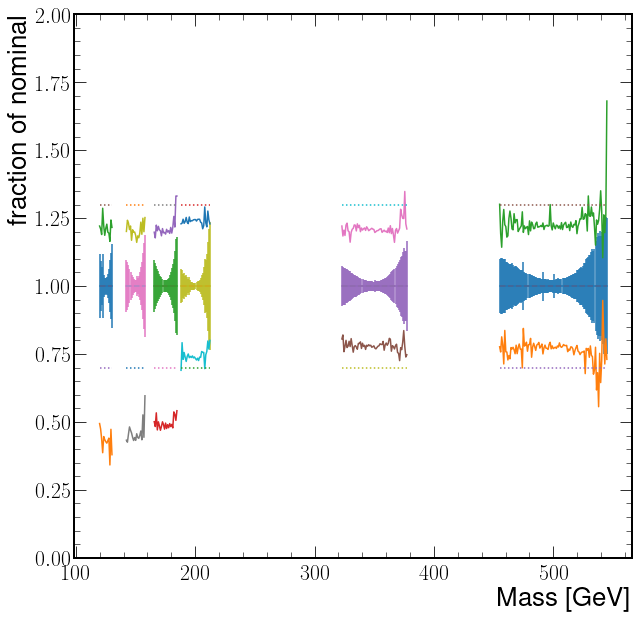

In [65]:
reg = 'SR1'
for mass in masses:
    print(make_sys_stats(mass,reg))    
plt.savefig('systematics/relative_sys_{}_{}.png'.format(era, reg))

/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.3716957998138034, 0.26132641897922926)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.37741743545654727, 0.3110549761356385)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.4717405175979339, 0.2686736707322379)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2902220966215967, 0.2495555272767711)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2416304388869439, 0.25664013637328575)


/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_4702/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.27912467779209804, 0.2828409805415335)


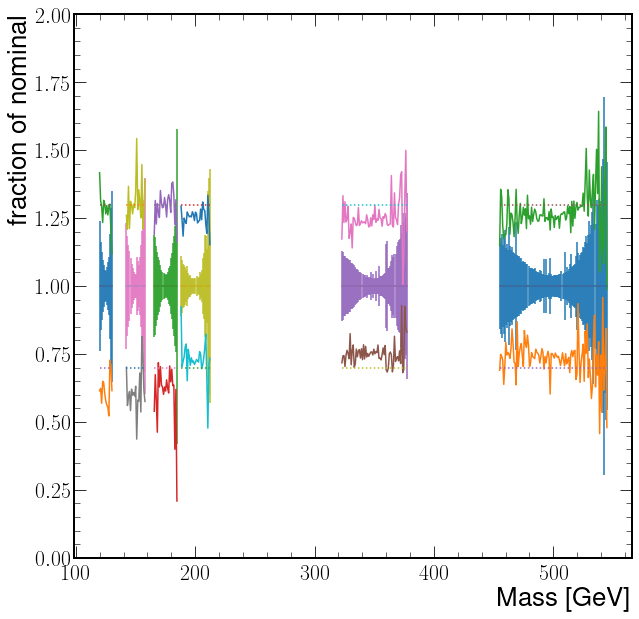

In [55]:
reg = 'SR2'
for mass in masses:
    print(make_sys_stats(mass,reg))    
plt.savefig('systematics/relative_sys_{}_{}.png'.format(era, reg))

In [68]:
df.mass

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
1602839    200.0
1602840    200.0
1602841    200.0
1602842    200.0
1602843    200.0
Name: mass, Length: 1602844, dtype: float64

In [140]:
def make_sys_comp_plot(nominal, down, up, fit_unc, reg, mass):
    fig, ax = plt.subplots()
    ax.plot(bin_centers, 0/fit)
    ax.plot(bin_centers,up/fit, color='blue')
    ax.plot(bin_centers,down/fit, color='blue', label='mc sys')
    ax.plot(bin_centers,fit_unc/fit, color='red', label='fit sys')
    ax.plot(bin_centers,-fit_unc/fit, color='red')
    ax.set_ylim(-1.25,1.25)
    ax.legend(title = "{} {}".format(reg, mass), loc=1)
    ax.set_xlabel('DiLepMass [GEV]')
    ax.set_ylabel('value/nominal(fit)')
    hep.cms.label(loc=0,ax=ax,lumi=lumi,year=era, data=False)
    fig.savefig('fits/bff/sys_plot_{}_{}_{}.png'.format(era, reg, mass))
    return fig 

125.0 SR1
150.0 SR1
175.0 SR1
200.0 SR1
350.0 SR1
500.0 SR1
125.0 SR2
150.0 SR2
175.0 SR2
200.0 SR2
350.0 SR2
500.0 SR2


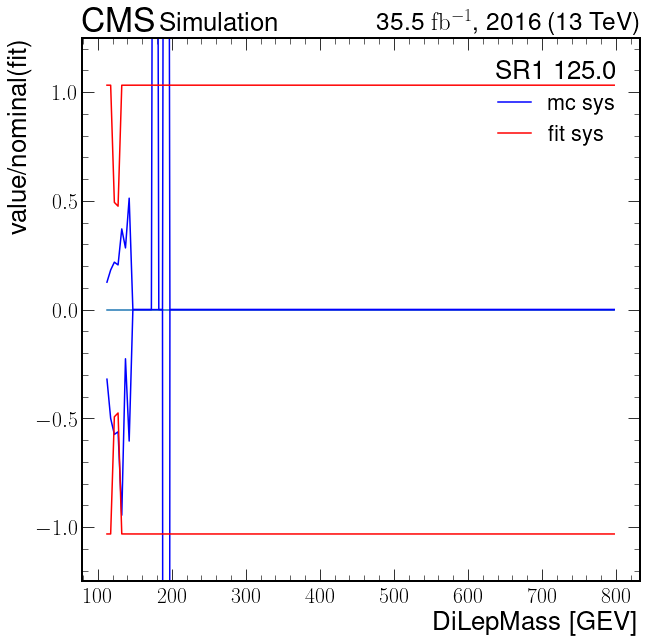

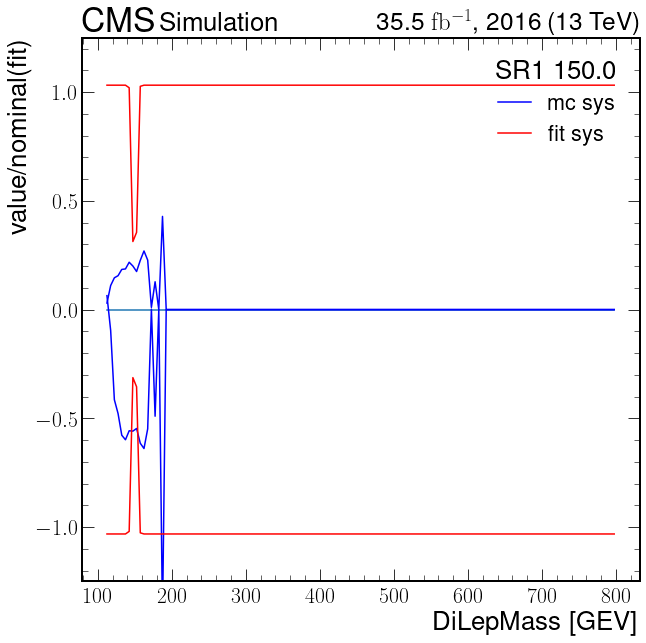

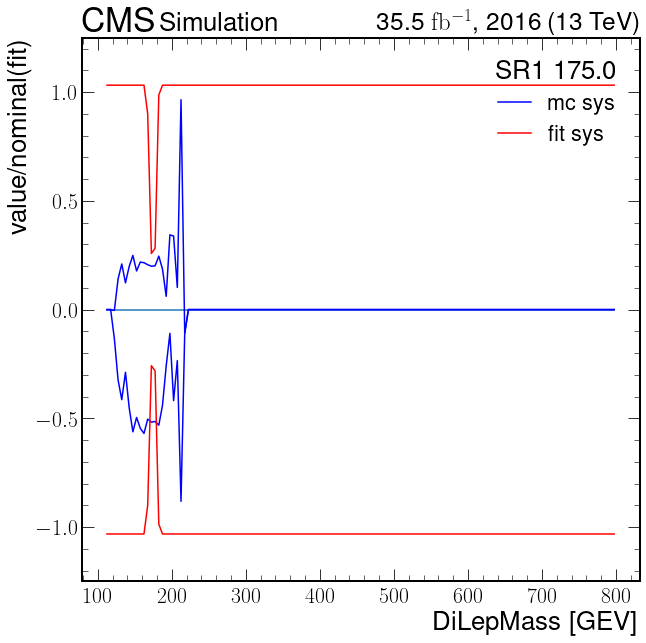

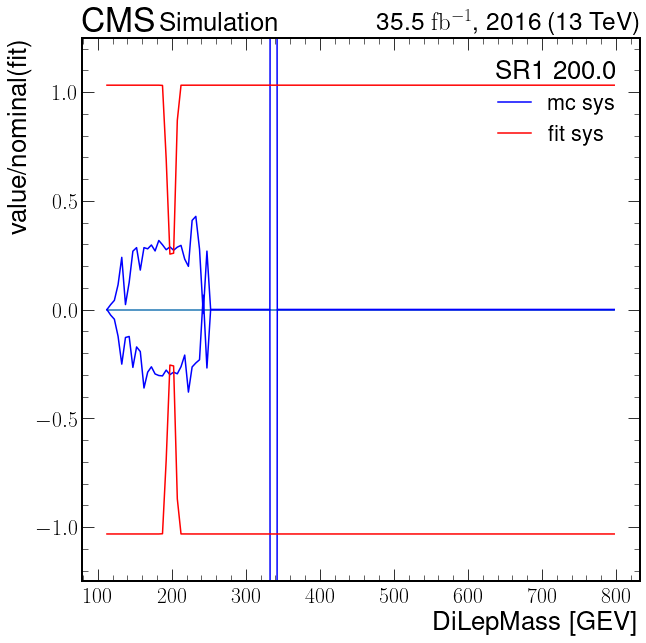

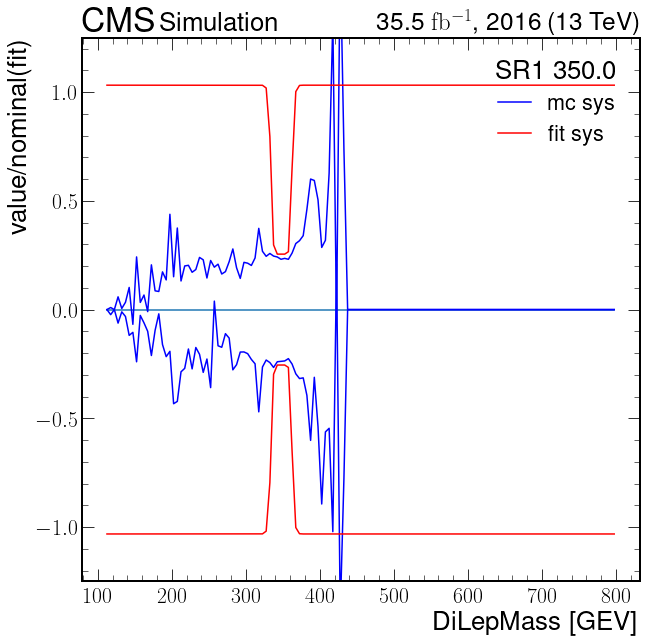

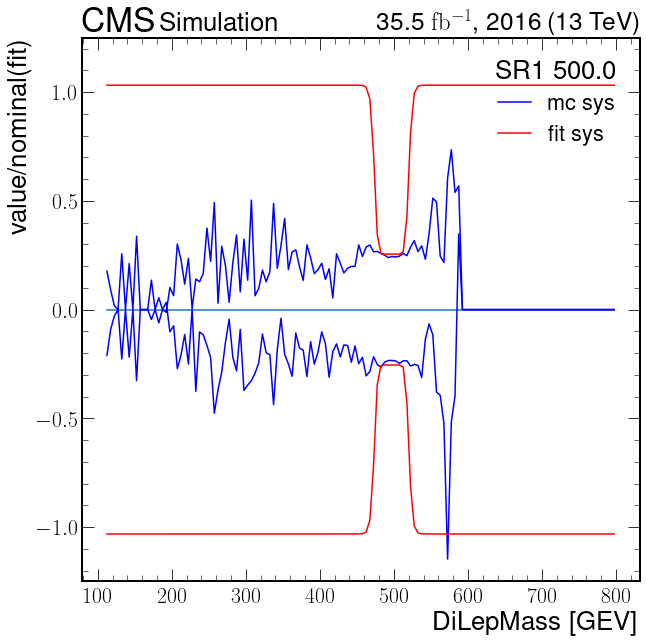

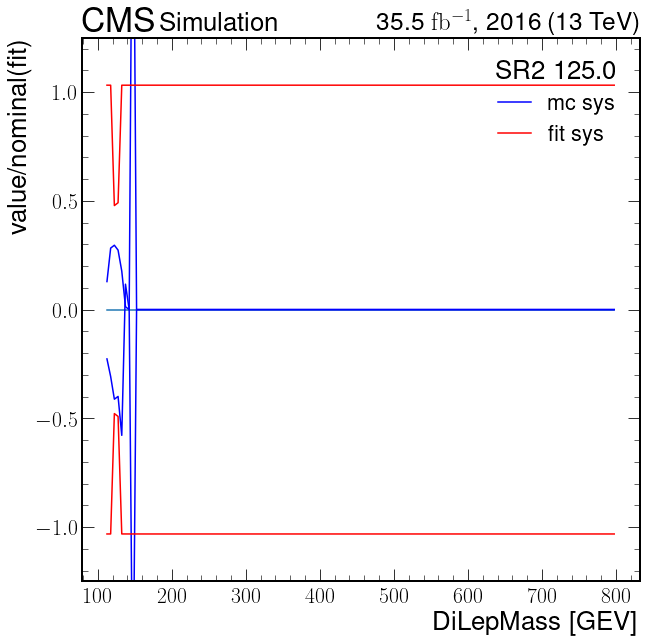

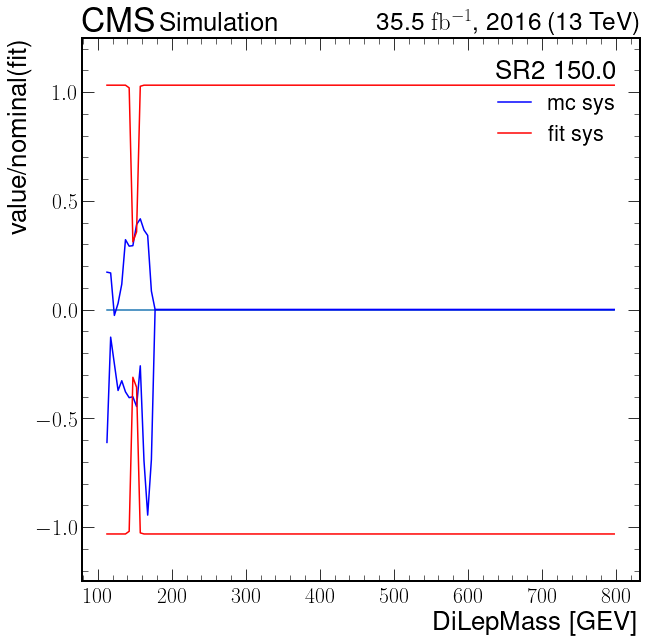

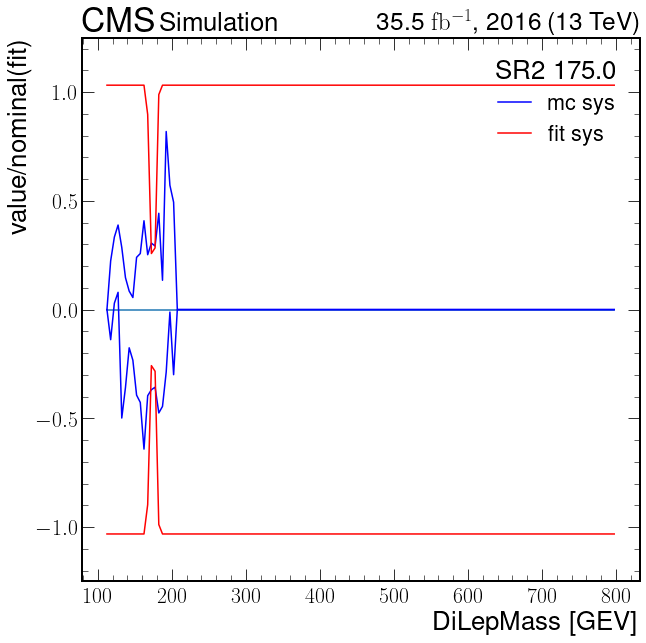

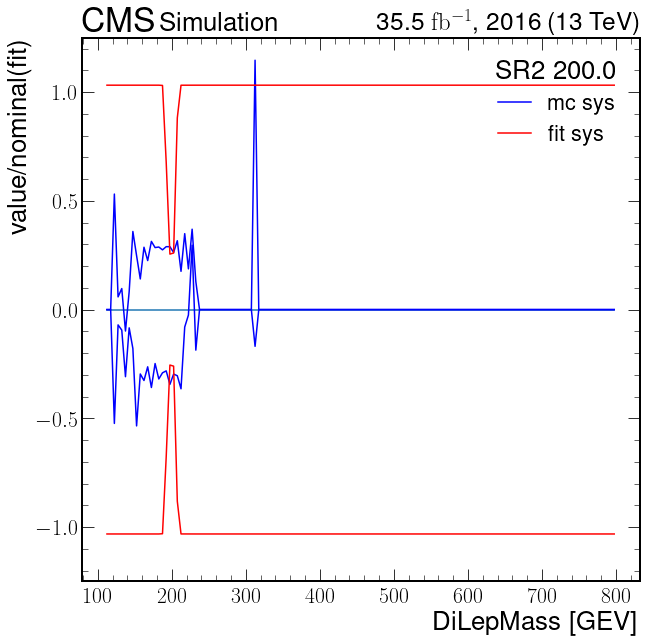

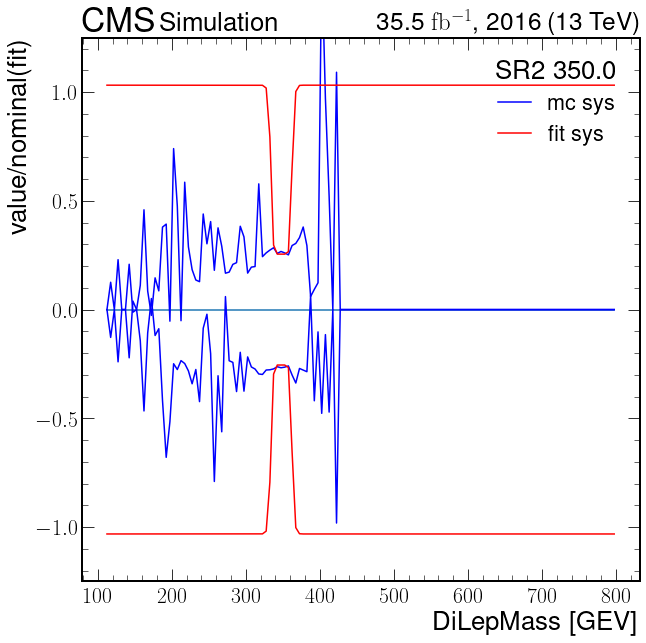

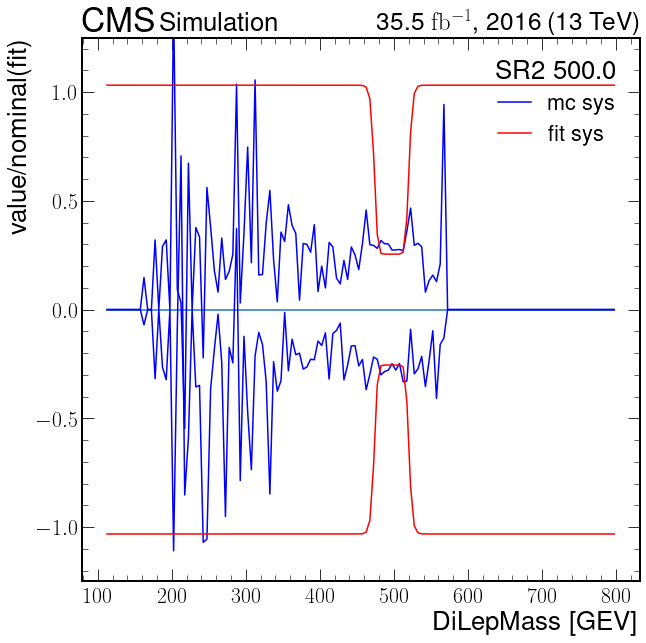

In [142]:
#make signal objects:
higgs_combine_plots = {}
for reg, mass_dict in plot_dict.items():
    higgs_combine_plots[reg] = {}
    for mass,signal_dict in mass_dict.items():
        print(mass, reg)
        fit = signal_dict['fit']
        fit_unc = signal_dict['fit_unc']
        # add constant systematic amount to account for mc systematics:
        sys_amount = .25
        fit_unc = (fit_unc**2 + (sys_amount*fit)**2)**.5
        hist = signal_dict['hist']
        bins = signal_dict['bins']
        bin_centers = compute_bin_centers(bins)
        nominal, down, up, std = make_sys(df[(df.mass==mass) & (df.dbs==0.04)], 'DiLepMass',reg, bins=bins)
        fit_up, fit_down = fit+fit_unc, fit-fit_unc
        make_sys_comp_plot(nominal, down, up, fit_unc, reg, mass)

        
        higgs_combine_plots[reg][mass] = {"fit": fit, 
                                         "fit_unc": fit_unc,
                                         "hist": nominal,
                                         "hist_down": down,
                                         "hist_up": up}

In [144]:
import pickle

In [155]:
with open('fits/bff/{}_signal_hists.png'.format(era), 'wb') as f:
    pickle.dump(higgs_combine_plots, f)

In [158]:
with open('fits/bff/{}_signal_hists.png'.format(era), 'rb') as f:
    test = pickle.load(f)

In [159]:
test

{'SR1': {125.0: {'fit': array([1.09132398e+01, 3.83324787e+01, 5.39838472e+02, 5.20529544e+02,
          1.15076001e+01, 1.66326748e+00, 4.97801224e-01, 2.05205920e-01,
          1.01635243e-01, 5.67445551e-02, 3.44774096e-02, 2.23100534e-02,
          1.51581920e-02, 1.07074795e-02, 7.80762750e-03, 5.84556372e-03,
          4.47540698e-03, 3.49256643e-03, 2.77108915e-03, 2.23073238e-03,
          1.81883431e-03, 1.49992425e-03, 1.24955636e-03, 1.05053565e-03,
          8.90544394e-04, 7.60612323e-04, 6.54108873e-04, 5.66066043e-04,
          4.92715138e-04, 4.31164574e-04, 3.79172423e-04, 3.34983569e-04,
          2.97211647e-04, 2.64752420e-04, 2.36719520e-04, 2.12396297e-04,
          1.91199376e-04, 1.72650850e-04, 1.56356862e-04, 1.41990996e-04,
          1.29281285e-04, 1.17999992e-04, 1.07955509e-04, 9.89858970e-05,
          9.09537089e-05, 8.37418090e-05, 7.72499857e-05, 7.13921905e-05,
          6.60942762e-05, 6.12921365e-05, 5.69301684e-05, 5.29599961e-05,
          4.93394